### **Business Understanding**

Regression Analysis: Building Models to Predict Store Sales Using Time Series Forecasting

**Introduction**
Time series forecasting involves making scientific predictions by analyzing historical data with timestamps. This process entails constructing models through a detailed examination of past data, which are then utilized to make informed projections, guiding future strategic decision-making. It's important to recognize that during the forecasting process, the future outcome is entirely unknown and can only be approximated through meticulous analysis and evidence-based assumptions.

**Project Objective**
The primary goal of this project is to predict product unit sales across various stores, aiming to enhance inventory management, refine marketing strategies, and optimize pricing decisions for Favorita Corporation. To achieve this objective, we employ a combination of time series analysis and regression-based machine learning algorithms within the CRISP-DM framework.

This analysis seeks to identify the most effective prediction model from a diverse set of machine learning algorithms tested. The chosen model will be recommended to Favorita Corporation, providing valuable insights to facilitate informed decisions regarding retail sales, promotional activities, and customer satisfaction. By leveraging time series regression analysis, we aim to achieve a robust and reliable forecast of store sales, thereby supporting strategic planning and operational efficiency.

HYPOTHESIS TESTING 

**Null Hypothesis (H0)**: The predictive model does not significantly improve the accuracy of unit sales forecasts for products at Favorita stores compared to a baseline model (e.g., a naive forecast using historical averages or a simple moving average).

**Alternative Hypothesis (H1)**: The predictive model significantly improves the accuracy of unit sales forecasts for products at Favorita stores compared to a baseline model.

**ANALYTICAL QUESTIONS**
1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.


In [1]:
#Import libraries needed for data manipulation, cleaning and visualizations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
# Models

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor


In [2]:
#import all the necessary libraries need to laod data from microsoft SQL server

import pyodbc    
from dotenv import dotenv_values
import warnings 

warnings.filterwarnings('ignore')

In [3]:
#Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('D:\mayaya project\Business-Forecasting-Model\.env')

#Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

#Create a connection string
connection_string = f"DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=200"

connection = pyodbc.connect(connection_string)
print("Connection successful")

Connection successful


In [4]:
query="SELECT * FROM dbo.oil"
query2="SELECT * FROM dbo.holidays_events"
query3= "SELECT * FROM dbo.stores"
oil_data= pd.read_sql(query, connection)
holidays_data= pd.read_sql(query2, connection)
stores_data= pd.read_sql(query3, connection)

#### Load dataset from Onedrive

In [5]:
sample_submission = pd.read_csv('../Data/sample_submission.csv')
test = pd.read_csv('../Data/test.csv')

#### Load datasets from Github

In [6]:
train= pd.read_csv(r"D:\mayaya project\Business-Forecasting-Model\Data\train.csv")
transactions= pd.read_csv(r"D:\mayaya project\Business-Forecasting-Model\Data\transaction.csv")

#### Data Preview and Investigation

In [7]:
holidays_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [8]:
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


stores_data.head()

In [9]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [10]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [11]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


### **Data wrangling**
Data wrangling, also known as data munging, involves transforming and mapping raw data into a more useful format for analysis. This process typically includes cleaning, structuring, and enriching the raw data to ensure its quality and usability for building predictive models. 

In [12]:
holidays_data

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [13]:
holidays_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [14]:
holidays_data.shape

(350, 6)

In [15]:
holidays_data.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [16]:
holidays_data.duplicated().sum()

np.int64(0)

#### **OBSERVATIONS**
1.Holiday Dataset Structure: The holiday dataset comprises 350 rows and 6 columns, providing a comprehensive overview of holiday-related data points.

2.Date Column Format: The date column is currently in an object (string) format, which will need to be converted to a datetime format for proper time series analysis.

3.Data Completeness: The dataset is complete with no missing values,  no duplicated values,  ensuring the integrity and reliability of the data for subsequent analysis.

4.Date Column Format: The date column is currently in an object (string) format and needs to be converted to a datetime format to facilitate proper time series analysis.

In [17]:
oil_data

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997
...,...,...
1213,2017-08-25,47.650002
1214,2017-08-28,46.400002
1215,2017-08-29,46.459999
1216,2017-08-30,45.959999


In [18]:
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [19]:
oil_data.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [20]:
oil_data.duplicated().sum()

np.int64(0)

#### **OBSERVATIONS**
1.Oil Dataset Structure: The oil dataset consists of 1218 rows and 2 columns, providing extensive information on oil prices over time.

2.Missing Values: The dataset contains 43 null values, which will need to be addressed through data cleaning techniques to ensure the accuracy of the analysis.

3.Data Uniqueness: There are no duplicate entries in the dataset, maintaining its integrity.

4.Date Column Format: The date column is currently in an object (string) format and needs to be converted to a datetime format to facilitate proper time series analysis.

In [21]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [22]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [23]:
transactions.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [24]:
transactions.duplicated().sum()

np.int64(0)

#### **OBSERVATIONS**
1.Data Completeness: The dataset is fully populated with no null values, ensuring high data quality and reliability for analysis.

2.Date Column Format: The date column is currently stored as an object (string) format. For accurate time series analysis, it is necessary to convert this column to a datetime format.

3.Data structure: it has 83488 rows and Three columns

In [25]:
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [26]:
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [27]:
stores_data.isnull().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [28]:
stores_data.duplicated().sum()

np.int64(0)

#### **OBSERVATIONS**
1.Correct Data Types: All attributes in the dataset are correctly formatted, ensuring that the data is ready for analysis without the need for additional type conversions.

2.No Duplicate Entries: The dataset contains no duplicate records, which maintains its integrity and ensures the uniqueness of each data point.**
1.Correct Data Types: All attributes in the dataset are correctly formatted, ensuring that the data is ready for analysis without the need for additional type conversions.

3.No Duplicate Entries: The dataset contains no duplicate records, which maintains its integrity and ensures the uniqueness of each data point.

In [29]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [31]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Data Visualization

Univariate Analysis

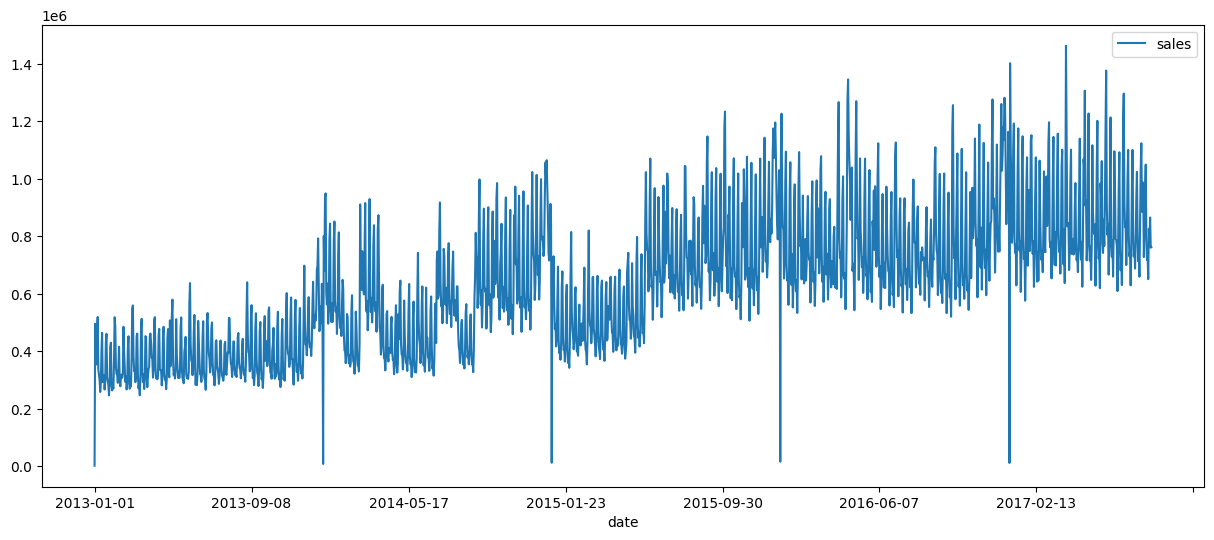

In [32]:
sales_trend = train.groupby('date').sales.sum().reset_index()    
sales_trend = sales_trend.set_index('date')

sales_trend.plot(figsize=(15, 6))
plt.show()

OBSERVATIONS
The training data exhibits an upward trend overall, indicating increasing sales over time. However, it is noteworthy that there is a significant decline in sales at the beginning of each year. This recurring pattern suggests potential seasonal factors or market dynamics that negatively impact sales during this period.

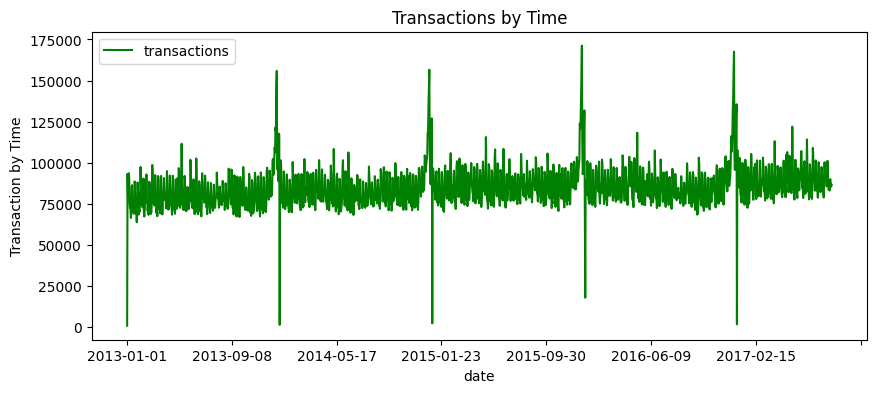

In [33]:
transaction_trend= transactions.groupby("date").transactions.sum().reset_index()
transaction_trend= transaction_trend.set_index("date")

transaction_trend.plot(figsize= (10,4), color= ("green"))
plt.title("Transactions by Time")
plt.ylabel("Transaction by Time")
plt.show()

OBSERVATIONS
A detailed analysis reveals a consistent upward trend in yearly transactions, with 2016 emerging as the year with the highest sales records. Despite this overall growth, the month-to-month transaction levels remain relatively stable throughout the years. Notably, there are sharp increases in transactions during year-end periods, highlighting a distinct seasonal pattern in sales activity.








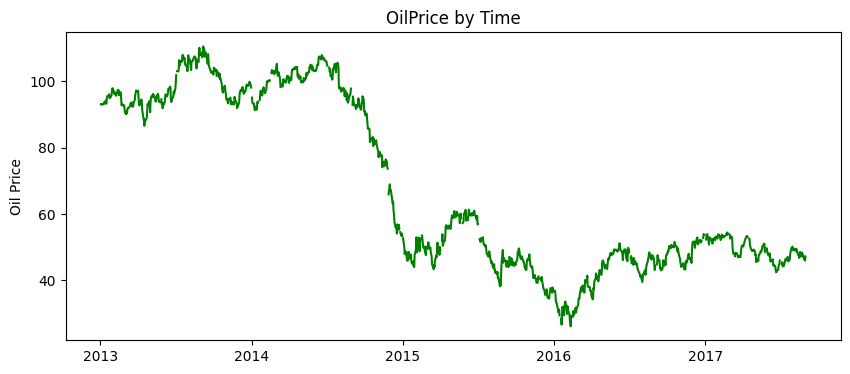

In [34]:
oil_data["date"]= pd.to_datetime(oil_data["date"])
oil_price_overtime= oil_data.groupby("date")["dcoilwtico"].mean().reset_index()
oil_price_by_time = oil_price_overtime.set_index('date')

plt.figure(figsize=(10,4))
plt.plot(oil_price_by_time.index,  oil_price_by_time["dcoilwtico"], color= "green")
plt.title("OilPrice by Time")
plt.ylabel("Oil Price")
plt.show()


OBSERVATIONS
The trend reveals a decline in oil prices starting from 2015. This downward trajectory is further interrupted by noticeable disruptions, which are linked to the presence of missing or NaN values in the dataset. These gaps underscore the need for careful data cleaning to ensure an accurate and continuous analysis of the oil price trends.

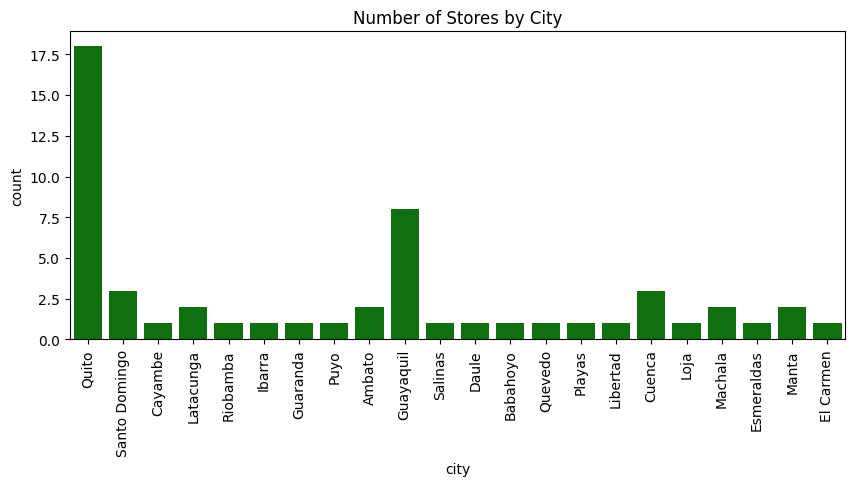

In [35]:
store_by_city= stores_data.set_index('store_nbr', inplace=True)
plt.figure(figsize=(10, 4))
sns.countplot(data=stores_data, x='city', color= 'green')
plt.xticks(rotation=90)
plt.title('Number of Stores by City')
plt.show()

OBSERVATIONS
The visual representation reveals that Quito and Guayaquil have the highest number of stores compared to other cities, which typically maintain an average of one store each. This concentration of stores in Quito and Guayaquil highlights their significance as major retail hubs within the dataset.








#### Holidays investigation

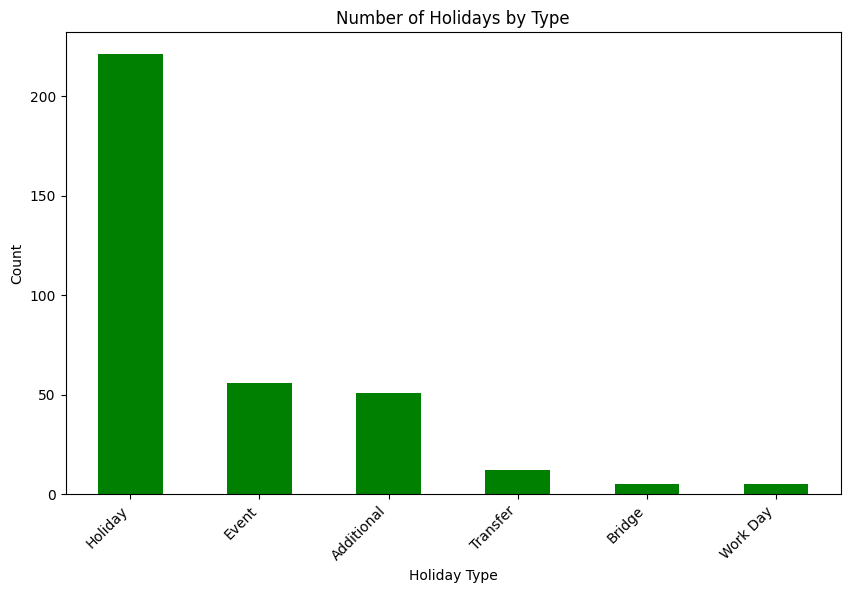

In [36]:
holiday_counts = holidays_data['type'].value_counts()

plt.figure(figsize=(10, 6))
holiday_counts.plot(kind='bar', color='green')
plt.title('Number of Holidays by Type')
plt.xlabel('Holiday Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

Data Preparation
Converting the date columns from their current format to a proper datetime format is essential. This transformation will enable accurate time series analysis and facilitate various date-based operations, such as sorting, filtering, and time-based aggregation, ensuring the integrity and precision of our analysis.

#### Convert date to datetime

In [37]:
train['date'] = pd.to_datetime(train['date'])
oil_data['date'] = pd.to_datetime(oil_data['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
holidays_data['date'] = pd.to_datetime(holidays_data['date'])
test['date'] = pd.to_datetime(test['date'])

#### **Answer Hypothesis Question**

In [38]:
sales_data = train['sales']

# Apply a logarithmic transformation (natural logarithm)
log_sales_data = np.log1p(sales_data)  # Using np.log1p to handle zero values safely

# Replace the 'sales' column with the transformed data in the DataFrame
train['sales'] = log_sales_data

# Perform first-order differencing
first_order_diff = train['sales'].diff(periods=1).dropna()

# Perform KPSS test on the differenced data
kpss_result = sm.tsa.kpss(first_order_diff)

# Extract KPSS test results for differenced data
kpss_statistic, p_value, lags, critical_values = kpss_result

# Print results
print(f'KPSS Statistic (Differenced Data): {kpss_statistic}')
print(f'p-value (Differenced Data): {p_value}')
print(f'Number of Lags Used (Differenced Data): {lags}')
print(f'Critical Values (Differenced Data): {critical_values}')

# Check if the differenced data is stationary
if p_value > 0.05:
    print('The differenced data is stationary.')
else:
    print('The differenced data is not stationary.')

KPSS Statistic (Differenced Data): 0.00010866464841100085
p-value (Differenced Data): 0.1
Number of Lags Used (Differenced Data): 411
Critical Values (Differenced Data): {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The differenced data is stationary.


#### **Answer Analytical Questions**

#### 1.Is the train dataset complete (has all the required dates)?

In [39]:
expected_dates= pd.date_range(start= train["date"].min(),end=train["date"].max())
missing_dates= expected_dates[~expected_dates.isin(train["date"])]

if missing_dates.empty:
    print("The train dataset is complete.")
else:
    print("The train dataset have the following missing dates:")
    for date in missing_dates:
        print(date)

The train dataset have the following missing dates:
2013-12-25 00:00:00
2014-12-25 00:00:00
2015-12-25 00:00:00
2016-12-25 00:00:00


Observations
The absence of data on December 25th in the train dataset for the years 2013, 2014, 2015, and 2016 suggests that no sales transactions were recorded on these dates. This gap is likely due to the organization observing the Christmas holiday, leading to a cessation of business activities and data collection during this period. This pattern is consistent across different weekdays for each year: Wednesday in 2013, Thursday in 2014, Friday in 2015, and Sunday in 2016, reinforcing the conclusion that the missing data corresponds to the holiday observance.








#### 2.Dates with highest and lowest Sales

Dates with the lowest sales for each year:
         year       date  sales
0        2013 2013-01-01    0.0
648648   2014 2014-01-01    0.0
1297296  2015 2015-01-01    0.0
1945944  2016 2016-01-01    0.0
2596374  2017 2017-01-01    0.0

Dates with the highest sales for each year:
         year       date      sales
562596   2013 2013-11-12  10.742292
1257246  2014 2014-12-08  10.722430
1916586  2015 2015-12-14  10.605408
2163723  2016 2016-05-02  11.733810
2760297  2017 2017-04-02  10.556428


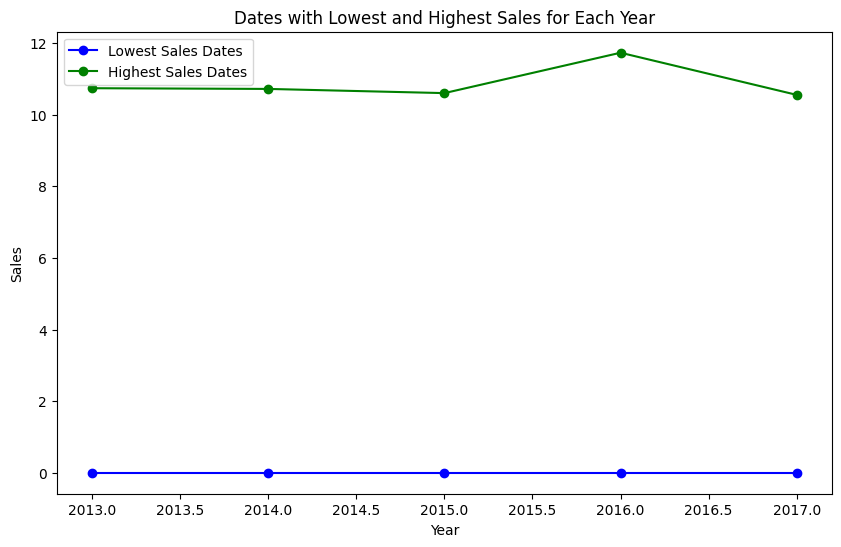

In [40]:
#train['date'] = pd.to_datetime(train_data['date'])
train['year'] = train['date'].dt.year
lowest_sales_dates = train.loc[train.groupby('year')['sales'].idxmin()][['year', 'date', 'sales']]
highest_sales_dates = train.loc[train.groupby('year')['sales'].idxmax()][['year', 'date', 'sales']]
print("Dates with the lowest sales for each year:")
print(lowest_sales_dates)
print("\nDates with the highest sales for each year:")
print(highest_sales_dates)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lowest_sales_dates['year'], lowest_sales_dates['sales'], color='blue', label='Lowest Sales Dates', marker='o')
ax.plot(highest_sales_dates['year'], highest_sales_dates['sales'], color='green', label='Highest Sales Dates', marker='o')
ax.set_xlabel('Year')
ax.set_ylabel('Sales')
ax.set_title('Dates with Lowest and Highest Sales for Each Year')
ax.legend()
plt.show()

#### 3. Compare the sales for each month across the years and determine which month of which year had the highest sales.

The month and year with the highest sales is May 2017 with total sales of 0.20 million.

Top 5 months with the highest sales (in millions):
month_name  year
May         2017    0.201465
July        2017    0.200174
March       2017    0.196250
December    2016    0.195397
June        2017    0.192700
Name: sales, dtype: float64


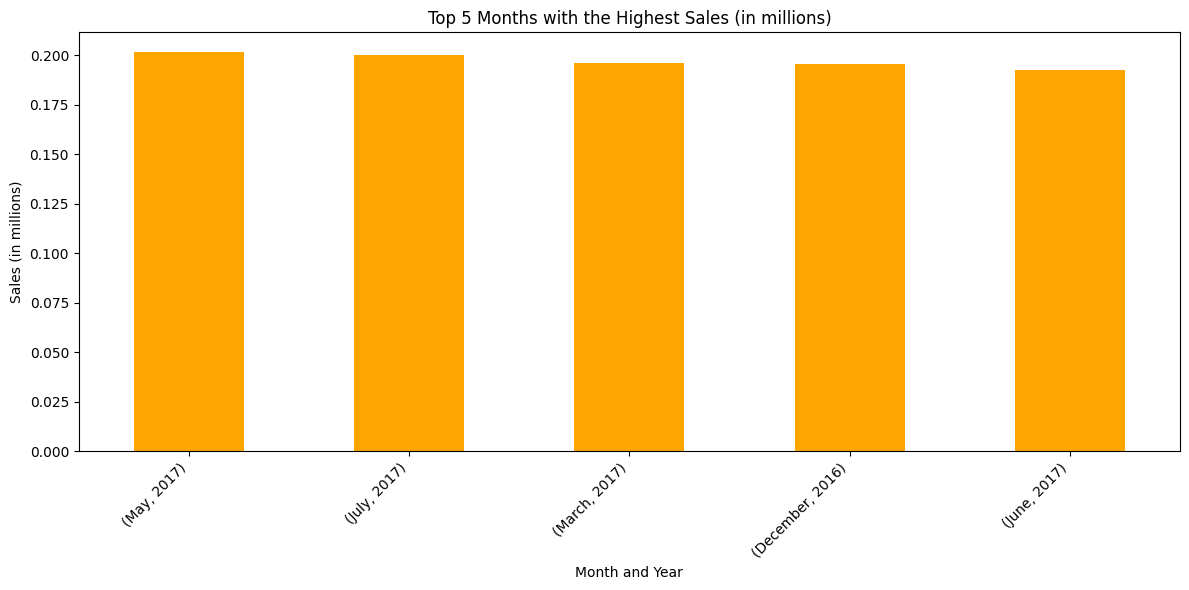

In [41]:
import matplotlib.pyplot as plt

# Ensure the 'date' column is in datetime format
train['date'] = pd.to_datetime(train['date'])

# Extract month name and year from the 'date' column
train['month_name'] = train['date'].dt.month_name()  # Get the full month name
train['year'] = train['date'].dt.year  # Extract the year

# Group by month name and year, then sum the sales
monthly_sales = train.groupby(["month_name", "year"])["sales"].sum()

# Convert sales values to millions
monthly_sales_millions = monthly_sales / 1_000_000

# Determine the month and year with the highest sales
highest_sales = monthly_sales_millions.idxmax()  # Get the index of the highest sales
highest_sales_value = monthly_sales_millions.max()  # Get the value of the highest sales

# Output the highest sales month, year, and value
print(f"The month and year with the highest sales is {highest_sales[0]} {highest_sales[1]} with total sales of {highest_sales_value:.2f} million.")

# Print the first five months with the highest sales
top_5_sales = monthly_sales_millions.sort_values(ascending=False).head(5)
print("\nTop 5 months with the highest sales (in millions):")
print(top_5_sales)

# Plot the sales comparison
fig, ax = plt.subplots(figsize=(12, 6))
top_5_sales.plot(kind='bar', color='orange', ax=ax)

ax.set_xlabel('Month and Year')
ax.set_ylabel('Sales (in millions)')
ax.set_title('Top 5 Months with the Highest Sales (in millions)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()


#### 4.Impact of April 16, 2016 earthquake on sales.

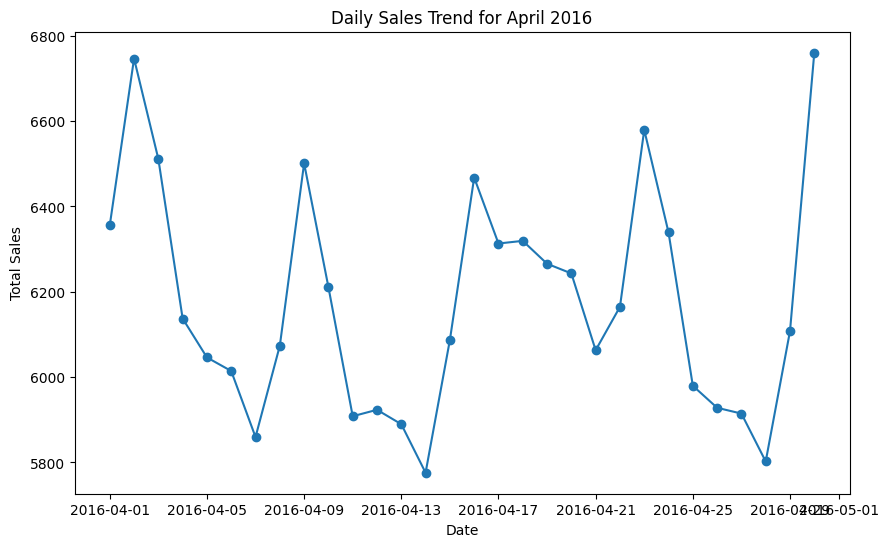

In [42]:
#filter out all the sales that occurred in April 2016
april_2016= train[(train['date']>='2016-04-1')& (train['date']<='2016-04-30')]
#april_2016
#group data by date and the sum of daily sales for April
sales_trend= april_2016.groupby(['date'])['sales'].sum()

plt.figure(figsize=(10, 6))
plt.plot(sales_trend.index, sales_trend.values, marker='o', linestyle='-')
plt.title('Daily Sales Trend for April 2016')
plt.xlabel('Date')
plt.ylabel('Total Sales')

plt.show()

Observations
The earthquake on April 16th, 2016, did not appear to have a noticeable impact on sales. The chart above shows a consistent upward trend in sales from April 16th, 2016, to April 22nd, 2016. Despite the occurrence of the earthquake, sales continued to follow their established pattern, indicating that the event did not disrupt consumer purchasing behavior or retail operations significantly during this period. This resilience suggests that either the earthquake's impact was minimal on the retail sector, or that there were effective measures in place to maintain sales continuity.


### 5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)

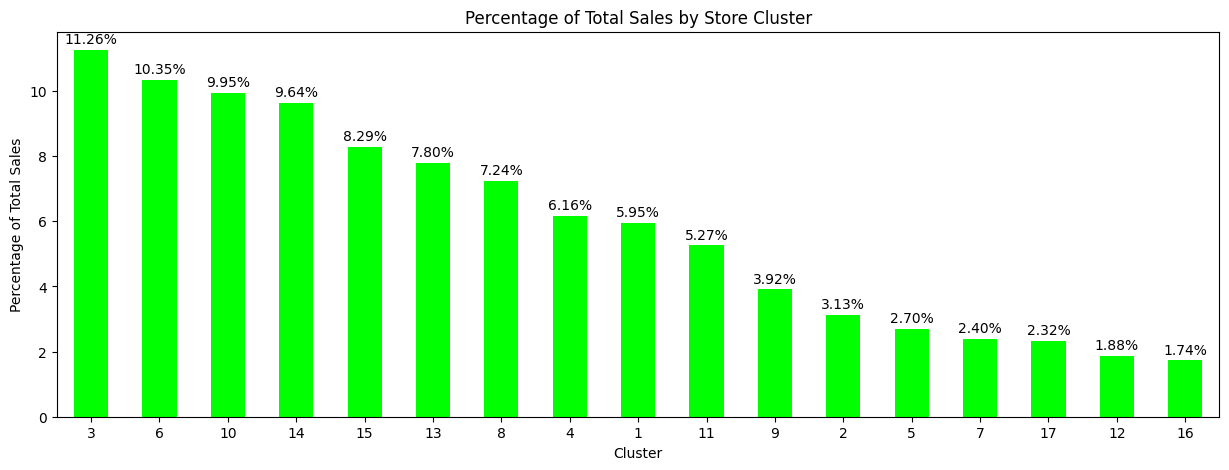

In [43]:
# Merge train data with the stores data
str_train = train.merge(stores_data, how='left', on='store_nbr')
# Calculate total sales by cluster
cluster_sales = str_train.groupby('cluster')['sales'].sum().sort_values(ascending=False)

# Calculate overall total sales
overall_sales = str_train['sales'].sum()

# Calculate the percentage of each cluster's sales over the overall sales
percentage_sales = (cluster_sales / overall_sales) * 100

# Plot a barplot to visualize the percentage of sales by cluster
plt.figure(figsize=(15, 5))
percentage_sales_sorted = percentage_sales.sort_values(ascending=False)
percentage_sales_sorted.plot.bar(color='lime')

# Add labels to the bars
for i, percentage in enumerate(percentage_sales_sorted):
    plt.text(i, percentage + 0.1, f"{percentage:.2f}%", ha='center', va='bottom')

plt.title('Percentage of Total Sales by Store Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage of Total Sales')
plt.xticks(rotation=0)
plt.show()


Notes
- There are 16 clusters
- Cluster 3, 6 and are the best selling cluster with each of them contributing above 10% of the total sales
- Cluster 3 is the best selling cluster with 11.26 percent of the total sales, cluster 6 is second best selling cluster with 10.35% of the total sales and cluster 10 is third best selling cluster with 9.95% of the total sales.
- The three worst selling clusters are 17, 12 and 16. Each of them contributes less than 2% of the total sales

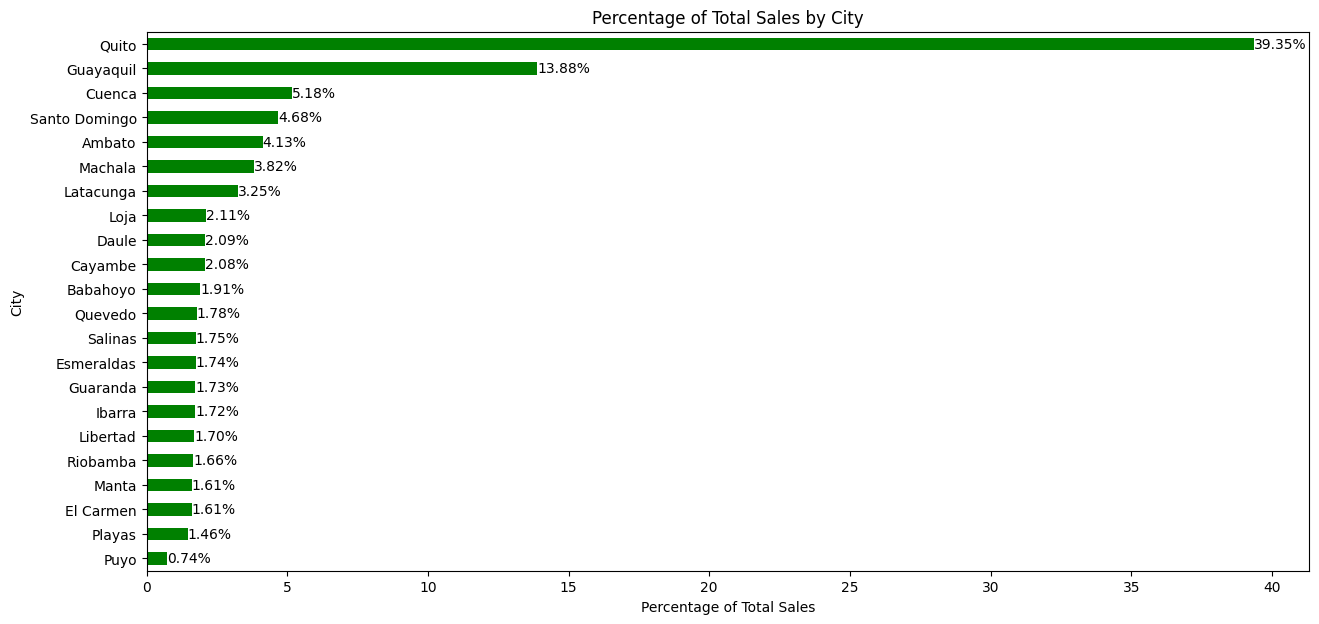

In [44]:
# Calculate total sales by city
city_sales = str_train.groupby('city')['sales'].sum().sort_values(ascending=False)

# Calculate the percentage of each city's sales over the overall sales
percentage_sales = (city_sales / overall_sales) * 100

# Plot a horizontal bar plot to visualize the percentage of sales by city
plt.figure(figsize=(15, 7))
percentage_sales_sorted = percentage_sales.sort_values(ascending=True)
percentage_sales_sorted.plot.barh(color='green')

# Add labels to the bars
for index, value in enumerate(percentage_sales_sorted):
    plt.text(value, index, f'{value:.2f}%', ha='left', va='center')

plt.title('Percentage of Total Sales by City')
plt.xlabel('Percentage of Total Sales')
plt.ylabel('City')
plt.show()

Notes
- Quito is the best location with 39.35 percent sales of the total sales. it is the best location by far considering the second best location is at 13.88 percent
- The worst performing locations are Puyo City and Playas City with 0.74 and 1.46 percent sales

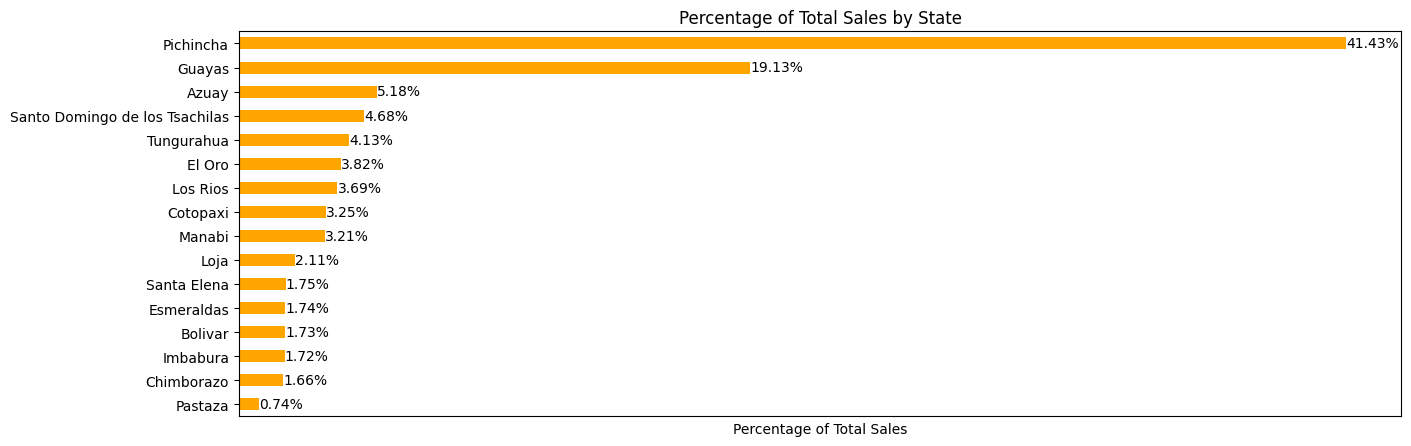

In [45]:
# Calculate total sales by state
state_sales = str_train.groupby('state')['sales'].sum().sort_values(ascending=False)

# Calculate overall total sales
overall_sales = str_train['sales'].sum()

# Calculate the percentage of each state's sales over the overall sales
percentage_sales = (state_sales / overall_sales) * 100

# Plot a horizontal bar plot to visualize the percentage of sales by state
plt.figure(figsize=(15, 5))
percentage_sales_sorted = percentage_sales.sort_values(ascending=True)
percentage_sales_sorted.plot.barh(color='orange')

# Add labels to the bars
for index, value in enumerate(percentage_sales_sorted):
    plt.text(value, index, f'{value:.2f}%', ha='left', va='center')

plt.title('Percentage of Total Sales by State')
plt.xlabel('Percentage of Total Sales')
plt.xticks([])
plt.ylabel('')
plt.show()

Notes
- Pichicha is by far the best performing state contributing 41.43% of the total sales. The second is Guayas at 19.13 percent of the total sales

- The worst performing state is Pastaza at 0.74% of the total sales

type
D    3,143,143.30
C    2,092,397.76
A    1,750,264.90
B    1,228,487.20
E      567,408.05
Name: sales, dtype: object


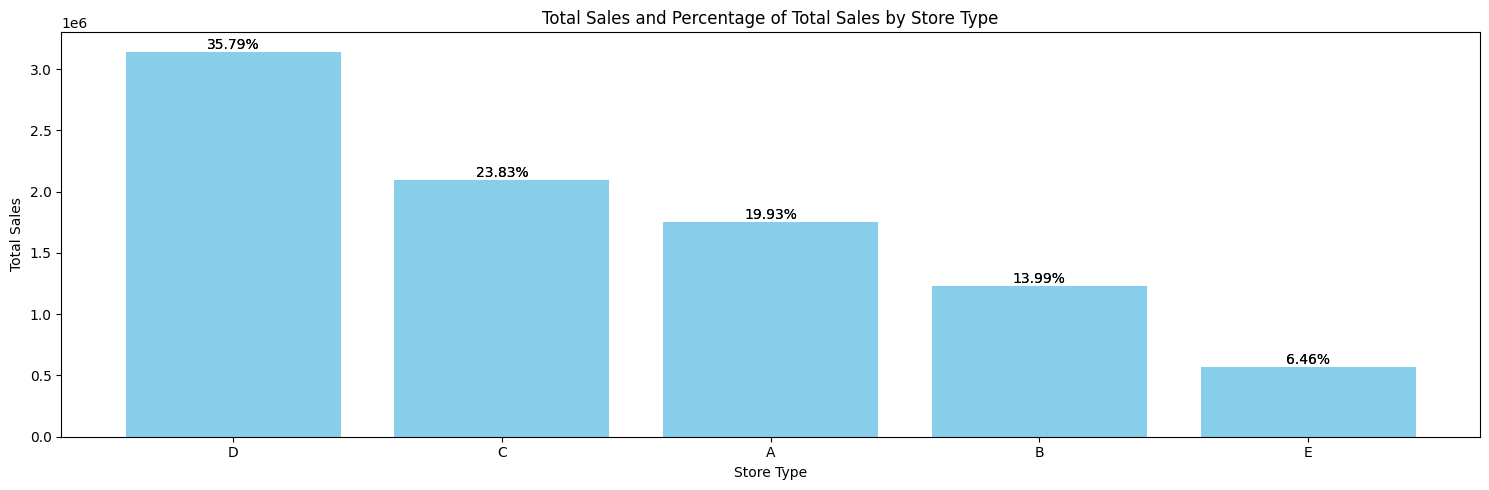

In [46]:
# Calculate total sales by store type
type_sales = str_train.groupby('type')['sales'].sum().sort_values(ascending=False)
print(type_sales.map('{:,.2f}'.format))

# Calculate overall total sales
overall_sales = str_train['sales'].sum()

# Calculate the percentage of each store type's sales over the overall sales
percentage_sales = (type_sales / overall_sales) * 100

# Plot a barplot to visualize the total sales and percentage of sales by store type
fig, ax = plt.subplots(figsize=(15, 5))

# Plot total sales
ax.bar(type_sales.index, type_sales, color='skyblue', label='Total Sales')

# Add percentage labels on top of the bars
for i, percentage in enumerate(percentage_sales):
    ax.text(i, type_sales[i] + 500, f"{percentage:.2f}%", ha='center', va='bottom', color='black')

# Add percentage of total sales as text above each bar
ax.bar_label(ax.containers[0], labels=[f"{percentage:.2f}%" for percentage in percentage_sales], label_type='edge', color='black')

ax.set_ylabel('Total Sales')
ax.set_xlabel('Store Type')
ax.set_title('Total Sales and Percentage of Total Sales by Store Type')
plt.tight_layout()
plt.show()

Notes
- Store types are A and D are the best performers with 25.79 and 32.23.83 percent sales respectively

- Store types E are the worst performers with 5.46%

#### 6.Are sales affected by promotions,oil price and holidays?

In [47]:
str_train_oil = str_train.merge(oil_data, how="inner", on='date')

In [48]:
str_train_oil.head()

,id,date,store_nbr,family,sales,onpromotion,year,month_name,city,state,type,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,January,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,January,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,January,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,January,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,2013,January,Quito,Pichincha,D,13,NaN


In [49]:
str_train_oil.isnull().sum()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
year               0
month_name         0
city               0
state              0
type               0
cluster            0
dcoilwtico     71280
dtype: int64

In [50]:
str_train_oil.duplicated().sum()

np.int64(0)

In [51]:
str_train_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2143746 entries, 0 to 2143745
Data columns (total 13 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   year         int32         
 7   month_name   object        
 8   city         object        
 9   state        object        
 10  type         object        
 11  cluster      int64         
 12  dcoilwtico   float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(4), object(5)
memory usage: 204.4+ MB


In [52]:
str_train_oil["dcoilwtico"].fillna(0, inplace= True)
str_train_oil.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
year           0
month_name     0
city           0
state          0
type           0
cluster        0
dcoilwtico     0
dtype: int64

6.1.**Are sales affected by promotions**

In [53]:
# Split Promoted items and those that were not promoted
import numpy as np
str_train_oil['onpromotion_encoded'] = np.where(str_train_oil['onpromotion'] >= 1, 1, 0)
str_train_oil['onpromotion_encoded'].value_counts()

onpromotion_encoded
0    1701970
1     441776
Name: count, dtype: int64

In [54]:
# Get sales data for items on promotion and not on promotion
sales_on_promotion = str_train_oil[str_train_oil['onpromotion_encoded'] == 1]['sales']
sales_not_on_promotion = str_train_oil[str_train_oil['onpromotion_encoded'] == 0]['sales']

# Calculate means of sales
mean_sales_on_promotion = sales_on_promotion.mean()
mean_sales_not_on_promotion = sales_not_on_promotion.mean()

print(f"Mean of sales on promotion: {mean_sales_on_promotion}")
print(f"Mean of sales not on promotion: {mean_sales_not_on_promotion}")

Mean of sales on promotion: 5.766659583788187
Mean of sales not on promotion: 2.1187044535105484


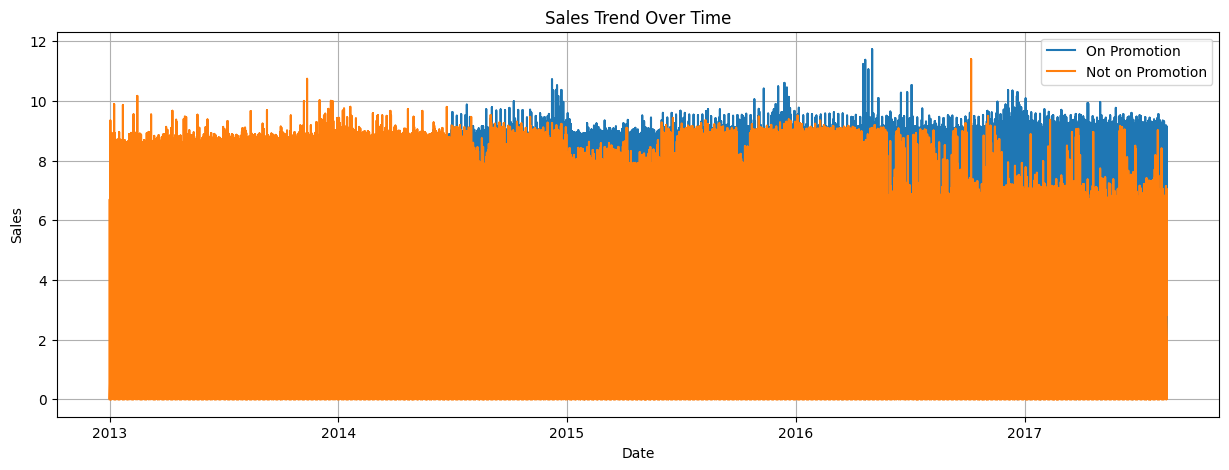

In [55]:
# Plot sales trend over time for items on promotion and items not on promotion
plt.figure(figsize=(15, 5))
plt.plot(str_train_oil[str_train_oil['onpromotion_encoded'] == 1]['date'], sales_on_promotion, label='On Promotion')
plt.plot(str_train_oil[str_train_oil['onpromotion_encoded'] == 0]['date'], sales_not_on_promotion, label='Not on Promotion')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

Notes
- It's clear that promotion activities have positive effects on sales
- There are more sales resulting from promotions as compared to to non-promotion activities

6.2. Are sales affected by oil prices

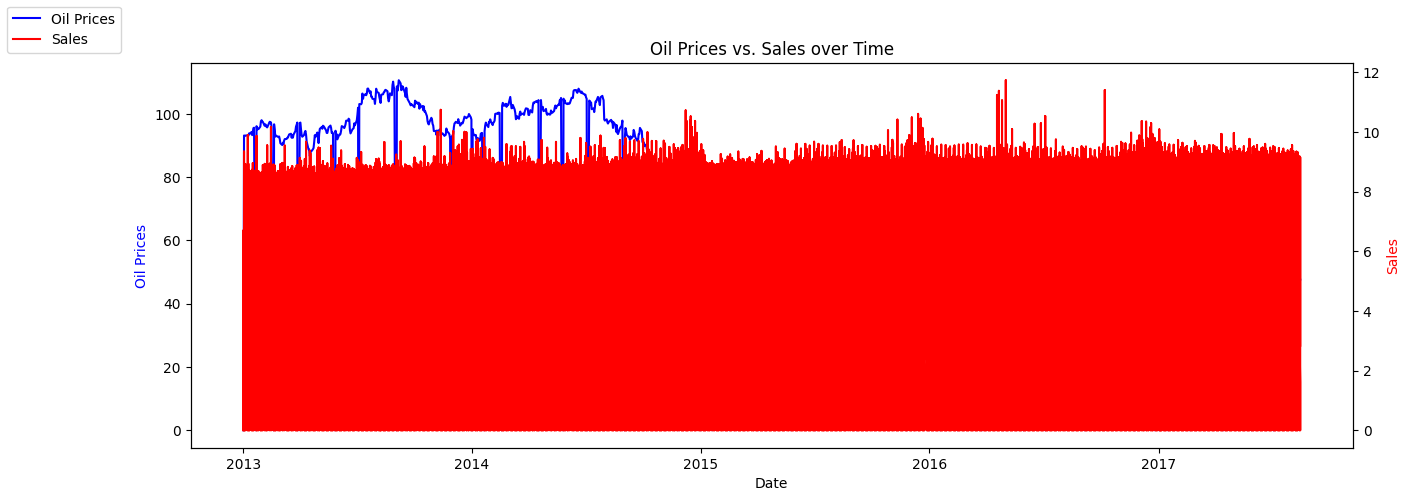

In [56]:
# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot oil prices on the primary y-axis
ax1.plot(str_train_oil['date'], str_train_oil['dcoilwtico'], color='blue', label='Oil Prices')
ax1.set_xlabel('Date')
ax1.set_ylabel('Oil Prices', color='blue')

# Create a secondary y-axis for sales
ax2 = ax1.twinx()
ax2.plot(str_train_oil['date'], str_train_oil['sales'], color='red', label='Sales')
ax2.set_ylabel('Sales', color='red')

# Add a legend
fig.legend(loc='upper left')

plt.title('Oil Prices vs. Sales over Time')

# Show plot
plt.show()

In [57]:
# Calculate the correlation between oil prices and sales
correlation = str_train_oil['dcoilwtico'].corr(str_train_oil['sales'])
print(f"Correlation between oil prices and sales: {correlation:.2f}")


Correlation between oil prices and sales: -0.14


Notes
- A negative correlation between oil prices and sales means that as oil prices increase, sales tend to decrease, and vice versa.

- A Pearson correlation coefficient of approximately -0.14 suggests a very weak negative correlation between oil prices and sales. This means that there is a slight tendency for sales to decrease as oil prices increase, but the correlation is not strong.

- Keep in mind that correlation does not imply causation, and there could be other factors influencing the relationship between oil prices and sales. Additionally, a correlation coefficient close to zero indicates a weak linear relationship, so it's essential to consider other factors that may affect sales.

6.3. Are sales affected by holidays

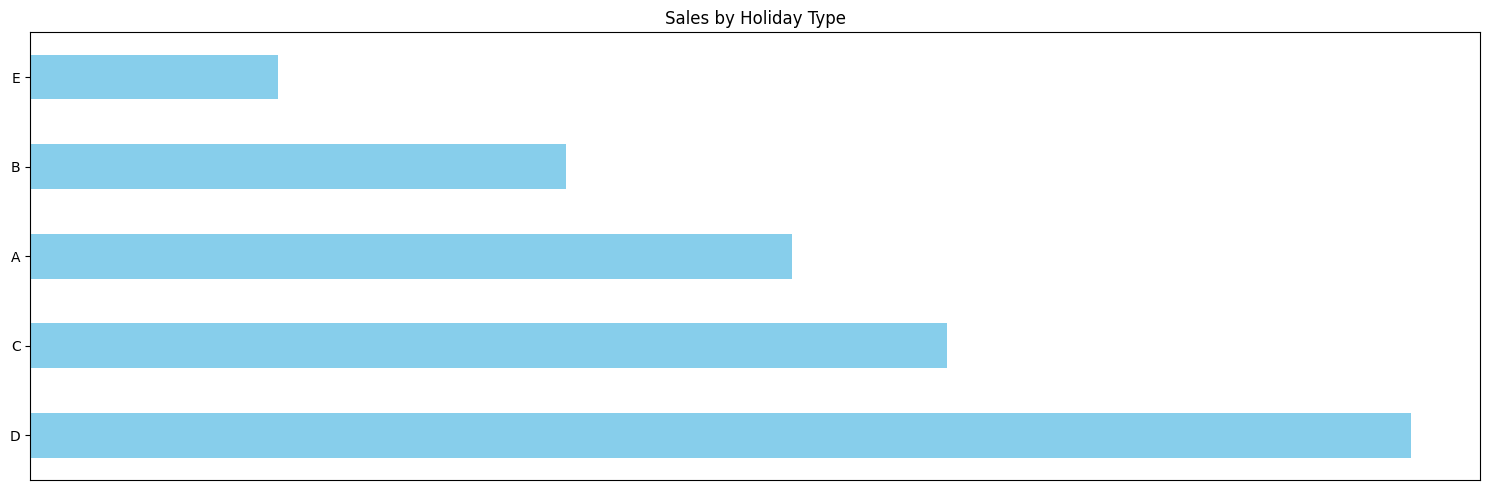

In [58]:
# Group the data by holiday type and calculate the sum of sales for each type
sales_by_holiday_type = str_train_oil.groupby("type").agg({"sales": "sum"}).sort_values(by="sales", ascending=False)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 5))

# Plot a horizontal bar chart of the sales by holiday type
sales_by_holiday_type.plot(kind="barh", ax=ax, color='skyblue')

# Add a title and labels
ax.set_title("Sales by Holiday Type")
ax.set_ylabel("Holiday Type")
ax.legend().set_visible(False)
plt.xticks([])
plt.ylabel('')
plt.tight_layout()
plt.show()

#### 7. What analysis can we get from the date and its extractable features?


7.1.Sales by month

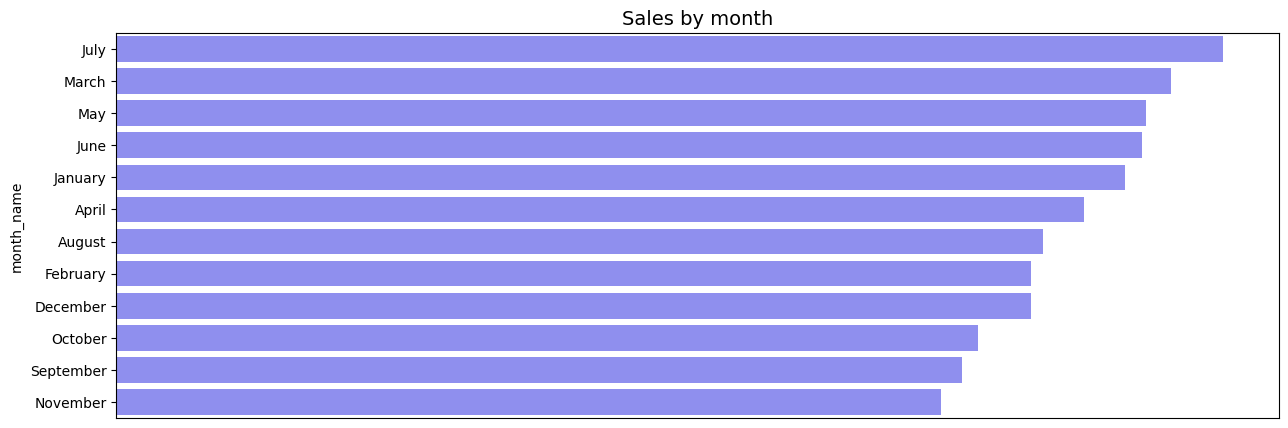

In [59]:
# Plotting a bar plot to show total sales by month
sales_by_month = str_train_oil.groupby('month_name')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(15, 5))
av = sns.barplot(y=sales_by_month.index, x=sales_by_month.values, color='blue', alpha=0.5,)
plt.xticks([])
plt.title('Sales by month', fontsize=14)
plt.show()

Notes
- Most sales are made in July and March. This can be attributed to the
- summer holiday season and end-of-quarter business activities.

#### 7.2. Sales by day of the week

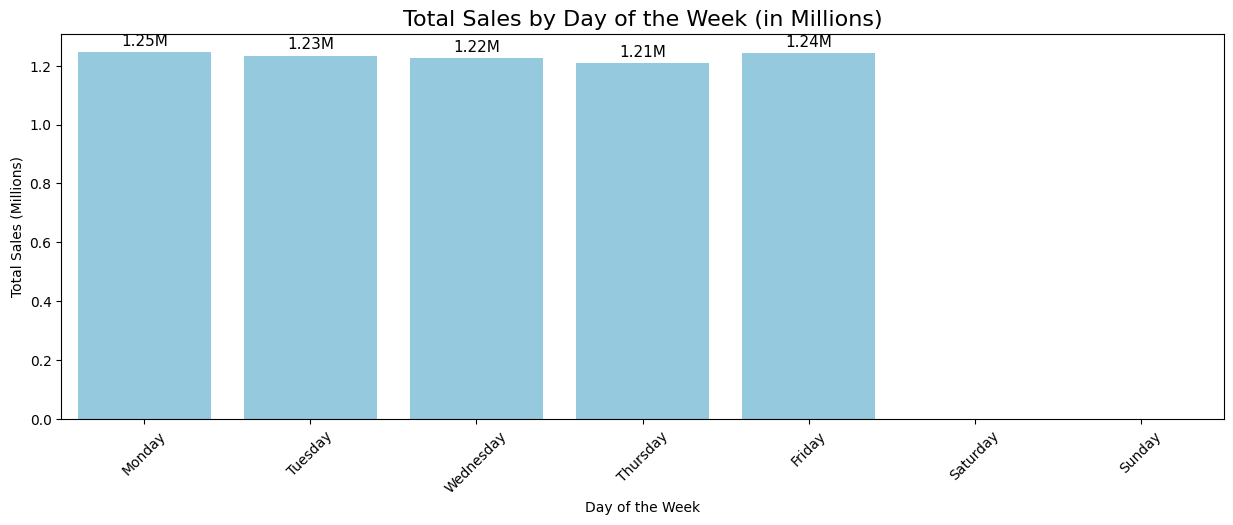

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'day_of_week' column is properly created
str_train_oil['day_of_week'] = pd.to_datetime(str_train_oil['date']).dt.day_name()

# Group by 'day_of_week' and sum the sales
sales_by_day = str_train_oil.groupby('day_of_week')['sales'].sum()

# Sort the days of the week in the correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sales_by_day = sales_by_day.reindex(day_order)

# Convert sales to millions
sales_by_day_millions = sales_by_day / 1_000_000

# Plotting
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=sales_by_day_millions.index, y=sales_by_day_millions.values, color='skyblue')
plt.title('Total Sales by Day of the Week (in Millions)', fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales (Millions)')
plt.xticks(rotation=45)

# Add labels on the bars (in millions)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}M', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()


Notes
- Sales is high on monday and friday

#### 7.3 Sales by day of Quarter

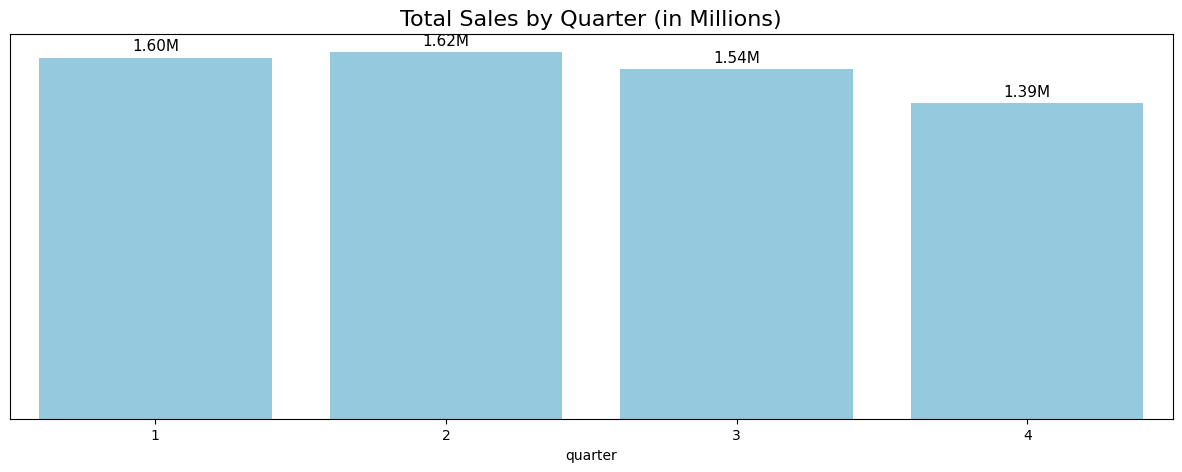

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'quarter' column is created from the 'date'
str_train_oil['quarter'] = pd.to_datetime(str_train_oil['date']).dt.quarter

# Group by 'quarter' and sum the sales
sales_by_quarter = str_train_oil.groupby('quarter')['sales'].sum().sort_values(ascending=False)

# Convert sales to millions
sales_by_quarter_millions = sales_by_quarter / 1_000_000

# Plotting
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=sales_by_quarter_millions.index, y=sales_by_quarter_millions.values, color='skyblue')
plt.title('Total Sales by Quarter (in Millions)', fontsize=16)
plt.xticks(rotation=0)
plt.yticks([])

# Add labels on the bars (in millions)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}M', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()


#### 7.4. Sales by day of the Month

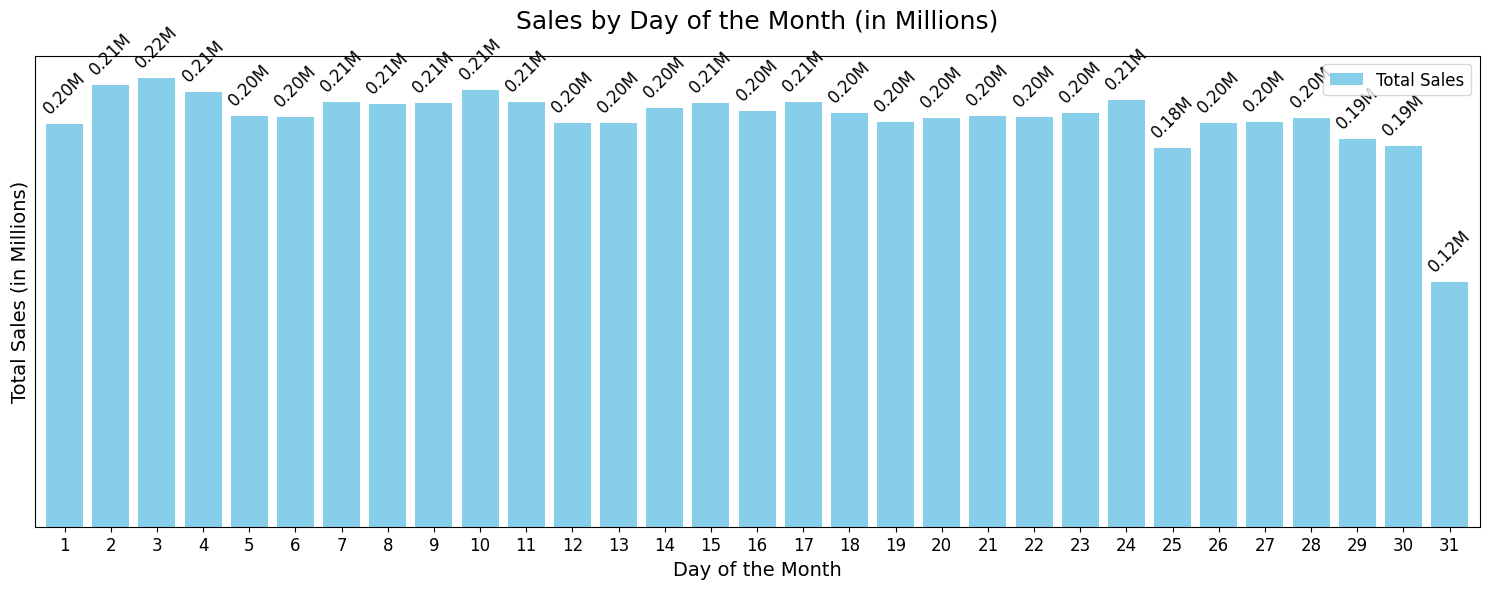

In [62]:
import matplotlib.pyplot as plt

# Sales by day of the month (in millions)
str_train_oil['day_of_month'] = pd.to_datetime(str_train_oil['date']).dt.day
sales_by_day_of_month = str_train_oil.groupby('day_of_month')['sales'].sum() / 1_000_000  # Convert to millions

# Plotting
plt.figure(figsize=(15, 6))
ax = sales_by_day_of_month.plot(kind='bar', 
                                color='skyblue', 
                                width=0.8, 
                                label='Total Sales')

plt.title('Sales by Day of the Month (in Millions)', fontsize=18, pad=20)
plt.xlabel('Day of the Month', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.ylabel('Total Sales (in Millions)', fontsize=14)
plt.yticks(fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}M', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 8), 
                textcoords='offset points', rotation=45)

# Remove unnecessary y-axis ticks
plt.yticks([])

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Show plot
plt.tight_layout()
plt.show()


Notes
- Highest sales occur on the 3rd day of the month, indicating strong start-of-month performance.
- Sales decrease towards month-end, with the 31st having the lowest sales.


#### 8. Which product family and stores did the promotions affect?

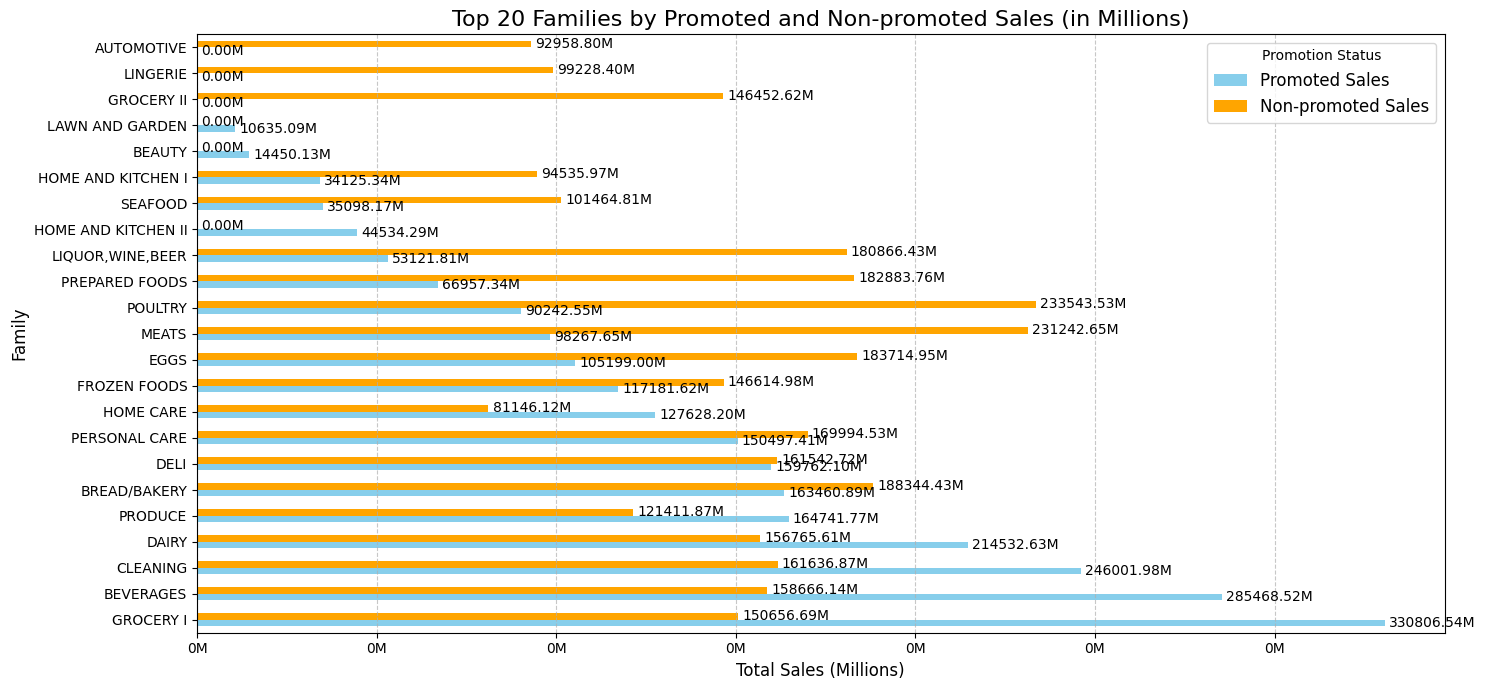

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the DataFrame to include only rows where onpromotion_encoded is equal to 1
promoted_data = str_train_oil[str_train_oil['onpromotion_encoded'] == 1]
non_promoted_data = str_train_oil[str_train_oil['onpromotion_encoded'] == 0]

# Group by the family column and sum up the sales for each group, then sort the result
grouped_sales_promotion = promoted_data.groupby('family')['sales'].sum().sort_values(ascending=False).head(20)
non_promoted_data_grp = non_promoted_data.groupby('family')['sales'].sum().sort_values(ascending=False).head(20)

# Rename columns for clarity
grouped_sales_promotion = grouped_sales_promotion.rename('Promoted Sales')
non_promoted_data_grp = non_promoted_data_grp.rename('Non-promoted Sales')

# Convert the result to a DataFrame
grouped_sales_promotion = pd.concat([grouped_sales_promotion, non_promoted_data_grp], axis=1)

# Plotting
ax = grouped_sales_promotion.plot(kind='barh', figsize=(15, 7), color=['skyblue', 'orange'])

# Title and labels
plt.title('Top 20 Families by Promoted and Non-promoted Sales (in Millions)', fontsize=16)
plt.xlabel('Total Sales (Millions)', fontsize=12)
plt.ylabel('Family', fontsize=12)

# Formatting x-axis in millions
xticks = ax.get_xticks() / 1e6  # Convert to millions
ax.set_xticklabels([f'{int(x)}M' for x in xticks])

# Add data labels to each bar
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.2fM', label_type='edge', padding=3, fontsize=10)

# Legend
plt.legend(title='Promotion Status', fontsize=12, loc='upper right')

# Adding grid lines for better visual clarity
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


Notes
- Grocery I is the most affected product family
- The effect is positive since most sales were made from the promoted items

#### 9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

1. Root Mean Squared Logarithmic Error (RMSLE):

- What it measures: How accurately the model predicts the target variable when its values vary widely.
- How it's calculated: First, it takes the logarithm of both the predicted and actual values. Then, it calculates the squared differences between these logarithms. Finally, it computes the mean of these squared differences and takes the square root.
- Why it's used Useful when you care more about relative errors across the entire range of the target variable. Root Mean Squared Error (RMSE):
- What it measures: The average size of the errors between predicted and actual values.
- How it's calculated: It calculates the squared differences between predicted and actual values, then computes the mean of these squared differences, and finally takes the square root.
- Why it's used: Helps in understanding the overall accuracy of the model's predictions.

2. Mean Squared Error (MSE):

- What it measures: Similar to RMSE, but without taking the square root.
- How it's calculated: It calculates the squared differences between predicted and actual values, then computes the mean of these squared differences.
- Why it's used: Provides a measure of the average magnitude of errors, but the unit is different from the target variable.

3. Mean Absolute Error (MAE):

- What it measures: The average absolute size of the errors between predicted and actual values.
- How it's calculated: It calculates the absolute differences between predicted and actual values, then computes the mean of these absolute differences.
- Why it's used: Gives a simple and easy-to-understand measure of prediction accuracy, especially when dealing with outliers.

**MAE can be greater than other metrics when there are large errors or outliers in the data because it treats all errors equally and doesn't square them. MAE counts all errors the same way, whether they're too high or too low. So, if there are some really big errors in our predictions, MAE adds them up just like the smaller errors, which can make its total bigger. The other metrics like RMSE or MSE handle these big errors differently, so they might not end up as big as MAE**

#### 10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

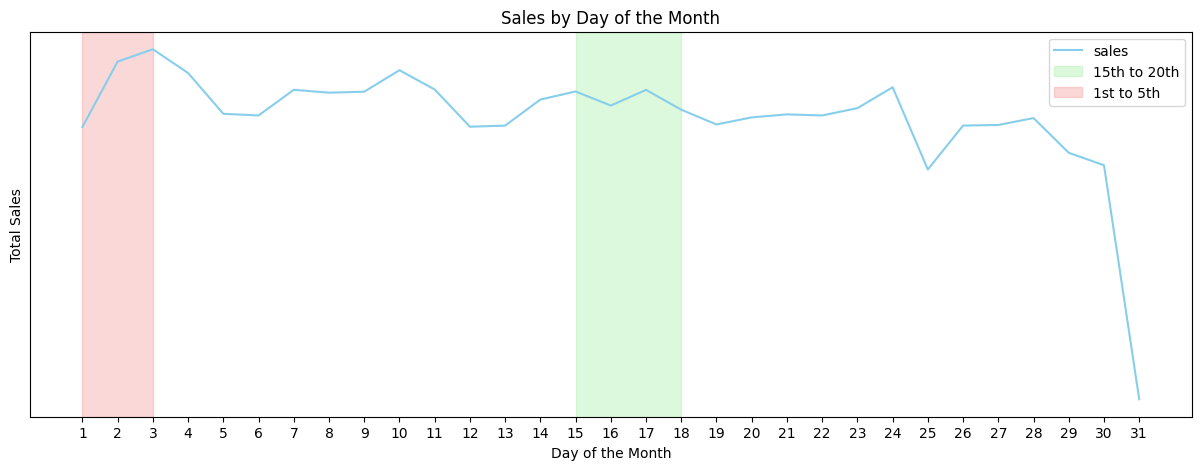

In [64]:
# Sales by day of the month
str_train_oil['day_of_month'] = str_train_oil['date'].dt.day
sales_by_day_of_month = str_train_oil.groupby('day_of_month')['sales'].sum()
sales_by_day_of_month.plot(kind='line', figsize=(15, 5),
                            xlabel='Day of the Month', 
                            ylabel='Total Sales', 
                            title='Sales by Day of the Month',
                            color='skyblue')

# Highlighting different periods with different colors
plt.axvspan(15, 18, color='lightgreen', alpha=0.3, label='15th to 20th')
plt.axvspan(1, 1 + 2, color='lightcoral', alpha=0.3, label='1st to 5th')

plt.xticks(range(1, 32), rotation='horizontal')
plt.yticks([])
plt.legend()
plt.show()

Notes
- After people get paid at the end of the month, sales go up. They peak around the second day of the month before coming down and stabilizing around the seventh day of the month.

- Sales also slightly rise after the 15th of the month payday, but not as much.

### **Feature Engineering and Modelling**

In [65]:
#split data into x and y

x= train.drop(['sales','id'], axis=1)

y= train['sales']

In [66]:
str_train_oil.head()

,id,date,store_nbr,family,sales,onpromotion,year,month_name,city,state,type,cluster,dcoilwtico,onpromotion_encoded,day_of_week,quarter,day_of_month
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,January,Quito,Pichincha,D,13,0.0,0,Tuesday,1,1
1,1,2013-01-01,1,BABY CARE,0.0,0,2013,January,Quito,Pichincha,D,13,0.0,0,Tuesday,1,1
2,2,2013-01-01,1,BEAUTY,0.0,0,2013,January,Quito,Pichincha,D,13,0.0,0,Tuesday,1,1
3,3,2013-01-01,1,BEVERAGES,0.0,0,2013,January,Quito,Pichincha,D,13,0.0,0,Tuesday,1,1
4,4,2013-01-01,1,BOOKS,0.0,0,2013,January,Quito,Pichincha,D,13,0.0,0,Tuesday,1,1


### LABEL ENCODED

In [67]:
label_encoder = LabelEncoder()

# Iterate through each column in the x dataset
for column in x.columns:
    # Check if the column data type is object (categorical) or bool
    if x[column].dtype == 'object':
        # Fit and transform the label encoder on the combined data
        x[column] = label_encoder.fit_transform(x[column])

In [68]:
X_train, X_eval, Y_train, Y_eval= train_test_split(x,y, test_size= 0.2, random_state= 42, shuffle= False)
 

In [69]:
# Define preprocessing steps for numerical and categorical features
numerical_features = x.select_dtypes(include='number').columns
categorical_features = x.select_dtypes(include='object').columns

In [70]:
# CREATE A PIPELINE FOR NUMERICAL AND CATEGORICAL DATA


numerical_data= Pipeline(steps=[
    ('num_imputer',SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
    
])


categorical_data= Pipeline(steps=[
    ('cat_imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder',OneHotEncoder(handle_unknown='ignore')),
    
    
])

Preprocessor= ColumnTransformer([
    ('numerical',numerical_data,numerical_features ),
    ('categorical',categorical_data,categorical_features)
])

### 1.XGBOOST

In [71]:
xgboost_model = Pipeline([
    ('preprocessor', Preprocessor),
    ('Xgboost_model', XGBRegressor())
])

xgboost_model.fit(X_train,Y_train)

xgboost_forecast = xgboost_model.predict(X_eval)

In [72]:
Y_eval = np.clip(Y_eval, a_min=0, a_max=None)
xgboost_forecast = np.clip(xgboost_forecast, a_min=0, a_max=None)

 #Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_eval,  xgboost_forecast)


# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(Y_eval,  xgboost_forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = msle**0.5

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')

Mean Squared Error (MSE): 0.5376409918392066
Mean Squared Logarithmic Error (MSLE): 0.07816847824431045
Root Mean Squared Error (RMSE): 0.7332400642621805
Root Mean Squared Logarithmic Error (RMSLE): 0.2795862626173011


#### Obsevation

The evaluation metrics for the XGBoost model demonstrate strong performance, indicating that the model is making accurate predictions with minimal errors. This conclusion is supported by the low values of Mean Squared Error (MSE), Mean Squared Logarithmic Error (MSLE), and Mean Absolute Error (MAE), all of which signify that the predictions closely match the actual values on average. Additionally, the moderate values of Root Mean Squared Error (RMSE) and Root Mean Squared Logarithmic Error (RMSLE) imply that the prediction errors, while present, are not excessively large. Overall, these metrics highlight the model's effectiveness in capturing the underlying patterns in the data and producing reliable forecasts.


 #### 2.LINEAR REGRESSION

In [73]:
linear_reg_model = Pipeline([
    ('preprocessor', Preprocessor),
    ('Linear_model', LinearRegression())
])

linear_reg_model.fit(X_train,Y_train)

linear_reg_forecast = linear_reg_model.predict(X_eval)

EVALUATE MODEL

In [74]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_eval, linear_reg_forecast)

# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(Y_eval, linear_reg_forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = msle**0.5

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')

Mean Squared Error (MSE): 4.998433299245328
Mean Squared Logarithmic Error (MSLE): 0.5129041464091669
Root Mean Squared Error (RMSE): 2.2357176251139874
Root Mean Squared Logarithmic Error (RMSLE): 0.7161732656342088


#### Observation
The Root Mean Squared Logarithmic Error (RMSLE) for the model is 0.71, which suggests that the model's performance is suboptimal. This relatively high error indicates that the model is struggling to accurately predict the logarithmic differences between the actual and predicted values. Consequently, we will explore alternative models to identify a more accurate and reliable option for our predictions.


### 3.DESCISION TREE MODEL

In [75]:
# Descision tree model
descision_tree = Pipeline([
    ('preprocessor', Preprocessor),
    ('descision_tree', DecisionTreeRegressor(random_state=42))
])

descision_tree.fit(X_train,Y_train)

descision_tree_forecast = descision_tree.predict(X_eval)

#### EVALUATE THE MODEL

In [76]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_eval, descision_tree_forecast)

# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(Y_eval, descision_tree_forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = msle**0.5

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')

Mean Squared Error (MSE): 0.4480325575299922
Mean Squared Logarithmic Error (MSLE): 0.06353886884117119
Root Mean Squared Error (RMSE): 0.6693523418424651
Root Mean Squared Logarithmic Error (RMSLE): 0.2520691747143454


#### Observation
The Decision Tree Regressor demonstrated superior performance with an RMSLE score of 0.25. This significantly lower error indicates that the Decision Tree Regressor more accurately captures the relationship between the actual and predicted values compared to the previous model. The improved RMSLE score suggests that this model is more effective at minimizing prediction errors and offers a more reliable option for our forecasting needs.

### 4.RANDOM FOREST MODEL

In [77]:
#from sklearn.ensemble import GradientBoostingRegressor
Random_forest_model = Pipeline([
    ('preprocessor', Preprocessor),
    ('descision_tree', RandomForestRegressor())
])

Random_forest_model.fit(X_train,Y_train)


Random_forest_model_forecast = Random_forest_model.predict(X_eval)


#### Evaluatethe Model

In [78]:
#Y_eval = np.clip(Y_eval, a_min=0, a_max=None)
#Gradient_model_forecast = np.clip(Gradient_model_forecast, a_min=0, a_max=None)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(Y_eval, 
Random_forest_model_forecast)

# Calculate Mean Squared Logarithmic Error (MSLE)
msle = mean_squared_log_error(Y_eval, Random_forest_model_forecast)


# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate Root Mean Squared Logarithmic Error (RMSLE)
rmsle = msle**0.5

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Squared Logarithmic Error (MSLE): {msle}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Root Mean Squared Logarithmic Error (RMSLE): {rmsle}')

Mean Squared Error (MSE): 0.41140960145645034
Mean Squared Logarithmic Error (MSLE): 0.06127774958386199
Root Mean Squared Error (RMSE): 0.6414121930992974
Root Mean Squared Logarithmic Error (RMSLE): 0.24754342969237134


#### Observation
The Random Forest Regressor also exhibited strong performance, achieving the same RMSLE score of 0.25 as the Decision Tree Regressor. Based on these results, both the Decision Tree and Random Forest models have proven to be effective, each demonstrating an RMSLE score of 0.25. These models accurately capture the relationship between actual and predicted values, making them reliable choices for our forecasting needs.

### **Recommendations**

Senior Management: Based on our findings, we recommend that senior management implement a Decision Tree Regressor for predicting retail sales. This model effectively captures both seasonal patterns and trends in time series data, providing reliable forecasts. Additionally, to further improve the model's accuracy, it is essential to enhance data quality by addressing outliers and filling in missing values.

Marketing Team: The marketing team can leverage the Decision Tree Regressor to predict the impact of promotions on retail sales. By analyzing the effects of past promotions, the team can refine its promotional strategies to maximize sales outcomes. Furthermore, the model is invaluable for forecasting sales of new products and assessing the potential impact of new product launches on overall sales performance. This predictive capability will enable the marketing department to make data-driven decisions and optimize their approach to boosting sales.






